In [1]:
import warnings
warnings.filterwarnings('ignore')
import argparse
import numpy as np
import networkx as nx
#import node2vec
from gensim.models import Word2Vec
import random

In [2]:
def parse_args():
    '''
    Parses the node2vec arguments.
    '''
    # load
    parser = argparse.ArgumentParser(description="Run node2vec.")
    # input 
    parser.add_argument('--input', nargs='?', default='../content/graph/karate.edgelist',
                        help='Input graph path')
    # out
    parser.add_argument('--output', nargs='?', default='../content/emb/karate.emb',
                        help='Embeddings path')
    # dimension
    parser.add_argument('--dimensions', type=int, default=128,
                        help='Number of dimensions. Default is 128.')
    # length of walks
    parser.add_argument('--walk-length', type=int, default=80,
                        help='Length of walk per source. Default is 80.')
    # num of walks
    parser.add_argument('--num-walks', type=int, default=10,
                        help='Number of walks per source. Default is 10.')
    # windowsize
    parser.add_argument('--window-size', type=int, default=10,
                        help='Context size for optimization. Default is 10.')
    # epoch
    parser.add_argument('--iter', default=1, type=int,
                        help='Number of epochs in SGD')
    # parallel workers
    parser.add_argument('--workers', type=int, default=8,
                        help='Number of parallel workers. Default is 8.')
    # p
    parser.add_argument('--p', type=float, default=1,
                        help='Return hyperparameter. Default is 1.')
    # q
    parser.add_argument('--q', type=float, default=1,
                        help='Inout hyperparameter. Default is 1.')
    # weighted
    parser.add_argument('--weighted', dest='weighted', action='store_true',
                        help='Boolean specifying (un)weighted. Default is unweighted.')
    parser.add_argument('--unweighted', dest='unweighted', action='store_false')
    parser.set_defaults(weighted=False)
    # directed
    parser.add_argument('--directed', dest='directed', action='store_true',
                        help='Graph is (un)directed. Default is undirected.')
    parser.add_argument('--undirected', dest='undirected', action='store_false')
    parser.set_defaults(directed=False)
    
    return parser.parse_args(args=[])

In [3]:
def read_graph():
    '''
    Reads the input network in networkx.
    '''
    # weighted
    if args.weighted:
        G = nx.read_edgelist(args.input, nodetype=int, data=(('weight', float),), create_using=nx.DiGraph())
    # unweighted
    else:
        G = nx.read_edgelist(args.input, nodetype=int, create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1
    # to undirected
    if not args.directed:
        G = G.to_undirected()

    return G

In [4]:
# set parameters according to parser
args = parse_args()
# read graph
nx_G = read_graph()
print (len(nx_G))

34


In [5]:
args

Namespace(input='../content/graph/karate.edgelist', output='../content/emb/karate.emb', dimensions=128, walk_length=80, num_walks=10, window_size=10, iter=1, workers=8, p=1, q=1, weighted=False, unweighted=True, directed=False, undirected=True)

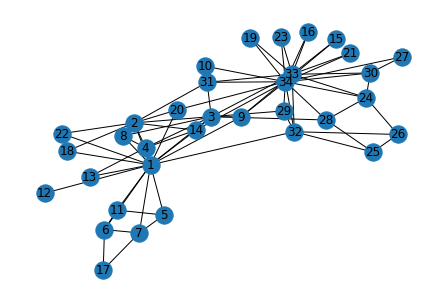

In [6]:
import matplotlib.pyplot as plt
nx.draw(nx_G, with_labels=True)
plt.show()

In [7]:
def alias_setup(probs):
    '''
    Compute utility lists for non-uniform sampling from discrete distributions.
    Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    for details
    '''
    K = len(probs)
    # q corrsespond to Prob
    q = np.zeros(K)
    # J Alias
    J = np.zeros(K, dtype=np.int)

    smaller = []
    larger = []
    
    # seperate prob into 2 groups, one for larger than one and one for smaller than 1
    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)
    
    # greed algo to setup
    # pseudo code step 3
    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        # update prob
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

In [8]:
def alias_draw(J, q):
    '''
    Draw sample from a non-uniform discrete distribution using alias sampling.
    '''
    K = len(J)

    kk = int(np.floor(np.random.rand()*K))
    # select self
    if np.random.rand() < q[kk]:
        return kk
    # select alias
    else:
        return J[kk]

In [9]:
class Graph():
    # initialize
    def __init__(self, nx_G, is_directed, p, q):
        self.G = nx_G
        self.is_directed = is_directed
        self.p = p
        self.q = q
    
    
    def node2vec_walk(self, walk_length, start_node):
        '''
        Simulate a random walk starting from start node.
        '''
        G = self.G
        # O(1) alias sampling
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]

        while len(walk) < walk_length:
            cur = walk[-1]
            # align with alias table
            cur_nbrs = sorted(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                # start scenario
                if len(walk) == 1:
                    walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
                # common scenario
                else:
                    # prev is node t in paper
                    prev = walk[-2]
                    next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0],
                        alias_edges[(prev, cur)][1])]
                    walk.append(next)
            else:
                break

        return walk
    def simulate_walks(self, num_walks, walk_length):
        '''
        Repeatedly simulate random walks from each node.
        '''
        G = self.G
        walks = []
        nodes = list(G.nodes())
        print ('Walk iteration:')
        for walk_iter in range(num_walks):
            print (str(walk_iter+1), '/', str(num_walks))
            # shuffle
            random.shuffle(nodes)
            for node in nodes:
                # node2vec_walk is a biased random walk
                walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

        return walks

    def get_alias_edge(self, src, dst):
        '''
        Get the alias edge setup lists for a given edge.
        '''
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []
        # section 3.2.2
        for dst_nbr in sorted(G.neighbors(dst)):
            if dst_nbr == src:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
            elif G.has_edge(dst_nbr, src):
                unnormalized_probs.append(G[dst][dst_nbr]['weight'])
            else:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
        
        # normarlize 
        norm_const = sum(unnormalized_probs)
        normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return alias_setup(normalized_probs)

    def preprocess_transition_probs(self):
        '''
        Preprocessing of transition probabilities for guiding the random walks.
        '''
        G = self.G
        is_directed = self.is_directed

        alias_nodes = {}
        # node alias sampling and normalize
        # node sampling is used for the start scienario (have no prevs)
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
            norm_const = sum(unnormalized_probs)
            normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = alias_setup(normalized_probs)
            if node == 2:
                print (unnormalized_probs)
                print (norm_const)
                print (normalized_probs)
                print (alias_nodes[node])

        alias_edges = {}
        triads = {}
        
        # edge alias sampling and normalize
        if is_directed:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
        else:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
                alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])
        
        print ('edges alias')
        print (alias_edges[(2, 3)])
        print (alias_edges[(3, 2)])
        
        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges

        return

In [10]:
G = Graph(nx_G, args.directed, args.p, args.q)

# generate alias table
G.preprocess_transition_probs()
#print ('nodes and edges alias sampling')

[1, 1, 1, 1, 1, 1, 1, 1, 1]
9
[0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111]
(array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1., 1., 1., 1., 1., 1., 1., 1., 1.]))
edges alias
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1., 1., 1., 1., 1., 1., 1., 1., 1.]))


In [11]:
def simulate_walks(self, num_walks, walk_length):
    '''
    Repeatedly simulate random walks from each node.
    '''
    G = self.G
    walks = []
    nodes = list(G.nodes())
    #print ('Walk iteration:')
    for walk_iter in range(num_walks):
        #print (str(walk_iter+1), '/', str(num_walks))
        # shuffle
        random.shuffle(nodes)
        for node in nodes:
            # node2vec_walk is a biased random walk
            walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

    return walks

In [12]:
def node2vec_walk(self, walk_length, start_node):
    '''
    Simulate a random walk starting from start node.
    '''
    G = self.G
    # O(1) alias sampling 
    alias_nodes = self.alias_nodes
    alias_edges = self.alias_edges

    walk = [start_node]
    
    while len(walk) < walk_length:
        cur = walk[-1]
        cur_nbrs = sorted(G.neighbors(cur))
        if len(cur_nbrs) > 0:
            # start  
            if len(walk) == 1:
                # alias_nodes[cur][0] -- alias table
                # alias_nodes[cur][1] -- probability table
                walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
            # len(senq) larger than 1
            else:
                # prev is node t in paper
                prev = walk[-2]
                next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0],
                    alias_edges[(prev, cur)][1])]
                walk.append(next)
        else:
            break

    return walk

In [13]:
def learn_embeddings(walks):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    # walks = [map(str, walk) for walk in walks]
    walk_lol = []
    for walk in walks:
        tmp = []
        for node in walk:
            tmp.append(str(node))
        walk_lol.append(tmp)
    # Use Gensim.Word2Vec
    model = Word2Vec(walk_lol, vector_size=args.dimensions, window=args.window_size, min_count=0, sg=1, workers=args.workers,
                     epochs=args.iter)
    # model.save_word2vec_format(args.output)
    # save embedding
    model.wv.save_word2vec_format(args.output)

    return model

In [14]:
walks = G.simulate_walks(args.num_walks, args.walk_length)

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [15]:
model = learn_embeddings(walks)
print ('finished')

finished


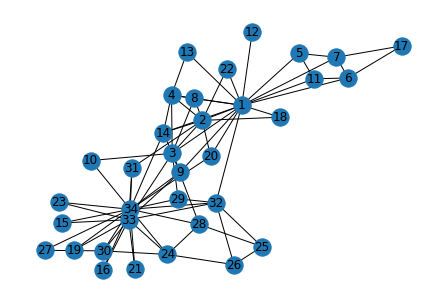

In [16]:
import matplotlib.pyplot as plt
nx.draw(nx_G, with_labels=True)
plt.show()

#Link prediction algorithm


In [17]:
node_embeddings = model.wv
G = nx.Graph()
words = list(model.wv.key_to_index.keys())
for node in words:
    G.add_node(node, features=node_embeddings[node])
for edge in G.edges():
    node1 = str(edge[0])                                             #here after node2vec I am taking only nodes and forming a graph with 0 edges.
    node2 = str(edge[1])
    if node1 in words or node2 in words:
        G.add_edge(node1, node2)

In [18]:
embedding_dict = {node: model.wv[node] for node in G.nodes()}
new_graph = nx.Graph()
new_graph.add_nodes_from(embedding_dict.keys())            #here with the nodes in the model that are produced after Node2vec I am building edges with the information of embedding information.
for node1 in embedding_dict:
    for node2 in embedding_dict:
        if node1 != node2:
            weight = model.wv.similarity(str(node1), str(node2))
            new_graph.add_edge(node1, node2, weight=weight)

In [19]:
print(new_graph.edges()) #A graph of model is formed with the edges being connected based on the embeddings values.

[('34', '1'), ('34', '33'), ('34', '3'), ('34', '2'), ('34', '32'), ('34', '4'), ('34', '24'), ('34', '14'), ('34', '30'), ('34', '9'), ('34', '6'), ('34', '8'), ('34', '7'), ('34', '28'), ('34', '25'), ('34', '26'), ('34', '29'), ('34', '11'), ('34', '31'), ('34', '5'), ('34', '20'), ('34', '13'), ('34', '18'), ('34', '19'), ('34', '22'), ('34', '17'), ('34', '16'), ('34', '23'), ('34', '21'), ('34', '27'), ('34', '10'), ('34', '15'), ('34', '12'), ('1', '33'), ('1', '3'), ('1', '2'), ('1', '32'), ('1', '4'), ('1', '24'), ('1', '14'), ('1', '30'), ('1', '9'), ('1', '6'), ('1', '8'), ('1', '7'), ('1', '28'), ('1', '25'), ('1', '26'), ('1', '29'), ('1', '11'), ('1', '31'), ('1', '5'), ('1', '20'), ('1', '13'), ('1', '18'), ('1', '19'), ('1', '22'), ('1', '17'), ('1', '16'), ('1', '23'), ('1', '21'), ('1', '27'), ('1', '10'), ('1', '15'), ('1', '12'), ('33', '3'), ('33', '2'), ('33', '32'), ('33', '4'), ('33', '24'), ('33', '14'), ('33', '30'), ('33', '9'), ('33', '6'), ('33', '8'), ('33

In [20]:
import networkx as nx
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt                                      #importing necessary packages.

In [21]:
print(new_graph) #getting info of new graph.

Graph with 34 nodes and 561 edges


In [22]:
#training_set, test_set = train_test_split(list(G.edges()), test_size=0.2)
training_set, test_set = train_test_split(list(new_graph.edges()), test_size=0.33, train_size=0.67)

G_train = nx.Graph()
G_train.add_edges_from(training_set)                                 #here from model graph I am splitting 33 percent of total edges to be test edges and remaining 67 percent of edges as training set. And from this training sample I built a graph of G_train.

In [23]:
pred_edges = list(nx.preferential_attachment(G_train, test_set)) #applied preferential attachment for train graph and new nodes from test set are added preferentially. After applying that algorithm taking total edges as pred edges.

In [24]:



actual_edges = test_set #test edges are taken as actual edges


pred_weights = [w for (u, v, w) in pred_edges]
actual_weights = [1 for (u, v) in actual_edges]       


rmse = sqrt(mean_squared_error(actual_weights, pred_weights)) # performing rmse on the actual edges weights and pred_edges weights. 

print(f"RMSE: {rmse}")

RMSE: 465.34016347392094
